# **Weak Supervision using Snorkel to classify Youtube Video comments as Spam or Not**

## Installing dependencies

In [1]:
!pip install numpy==1.19.5
!pip install pandas==1.1.5
!pip install wget==3.2
!pip install matplotlib==3.2.2
!pip install utils==1.0.1
!pip install snorkel==0.9.6
!pip install scikit-learn==0.21.3
!pip install textblob==0.15.3
!pip install treedlib==0.1.3
!pip install numbskull==0.1.1
!pip install spacy==2.2.4

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=75e6814238f5edbbb8fcea60f6b8669f9b8a2d4ed5d245841d53603ddd1d295d
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 144 kB 4.2 MB/s 
     |████████████████████████████████| 6.7 MB 17.5 MB/s 
     |████████████████████████████████| 1.7 MB 56.2 MB/s 
     |████████████████████████████████| 3.8 MB 47.9 MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556009 sha256=a7621e47db71cb6453494e0c1ef29ebd1fbd2a4be3879365a1d6ec2d49f70379
  Stored in directory: /root/.cache/pip/wheels/44/e6/b8/4efaab31158e9e9ca9ed80b11f6b11130bac9a9672b3cbbeaf
Successfully built networkx
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: scikit

In [2]:
!pip install tensorflow==1.15
!pip install tensorboard==1.15
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 412.3 MB 23 kB/s 
     |████████████████████████████████| 503 kB 55.7 MB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=5bc026c598948395fea167400d497186368fc540ba85896455cb0deaf0248675
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:
      Successfully uninstalled tensorflow-2.7.0
ERROR: pip's dependency resolver

## Downloading Data

In [8]:
import os
import wget

import zipfile
import shutil

file_link = "http://archive.ics.uci.edu/ml/machine-learning-databases/00380/YouTube-Spam-Collection-v1.zip"

os.makedirs("content", exist_ok= True)
if not os.path.exists("content/YouTube-Spam-Collection-v1.zip"):
    wget.download(file_link, out="content/")
else:
    print("File already exists")

with zipfile.ZipFile("content/YouTube-Spam-Collection-v1.zip", 'r') as zip_ref:
    zip_ref.extractall("content/")

shutil.rmtree("content/__MACOSX")
os.remove("content/YouTube-Spam-Collection-v1.zip")
os.listdir("content")

['Youtube03-LMFAO.csv',
 'Youtube05-Shakira.csv',
 'Youtube01-Psy.csv',
 'Youtube02-KatyPerry.csv',
 'Youtube04-Eminem.csv']

In [9]:
!git clone https://github.com/snorkel-team/snorkel-tutorials.git

source = "content/"
destination = "snorkel-tutorials/spam/data/"

os.makedirs(destination, exist_ok= True)

files = os.listdir(source)

for file in files:
    new_path = shutil.move(f"{source}/{file}", destination)

os.chdir("snorkel-tutorials/spam")

Cloning into 'snorkel-tutorials'...
remote: Enumerating objects: 1104, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 1104 (delta 14), reused 18 (delta 8), pack-reused 1059
Receiving objects: 100% (1104/1104), 3.53 MiB | 10.98 MiB/s, done.
Resolving deltas: 100% (729/729), done.


## Imports

In [5]:
import re
import glob

import utils

from snorkel.analysis import get_label_buckets

from snorkel.labeling import labeling_function
from snorkel.labeling import LFAnalysis
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LabelingFunction
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling.model import LabelModel
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.labeling.lf.nlp import nlp_labeling_function

from snorkel.preprocess import preprocessor
from snorkel.preprocess.nlp import SpacyPreprocessor

from snorkel.utils import probs_to_preds

from textblob import TextBlob

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def load_spam_dataset(load_train_labels: bool = False, split_dev_valid: bool = False):
    filenames = sorted(glob.glob("data/Youtube*.csv"))
    dfs = []
    for i, filename in enumerate(filenames, start=1):
        df = pd.read_csv(filename)
        # Lowercase column names
        df.columns = map(str.lower, df.columns)
        # Remove comment_id field
        df = df.drop("comment_id", axis=1)
        # Add field indicating source video
        df["video"] = [i] * len(df)
        # Rename fields
        df = df.rename(columns={"class": "label", "content": "text"})
        # Shuffle order
        df = df.sample(frac=1, random_state=123).reset_index(drop=True)
        dfs.append(df)

    df_train = pd.concat(dfs[:4])
    df_dev = df_train.sample(100, random_state=123)

    if not load_train_labels:
        df_train["label"] = np.ones(len(df_train["label"])) * -1
    df_valid_test = dfs[4]
    df_valid, df_test = train_test_split(
        df_valid_test, test_size=250, random_state=123, stratify=df_valid_test.label
    )

    if split_dev_valid:
        return df_train, df_dev, df_valid, df_test
    else:
        return df_train, df_test

In [11]:
df_train, df_test = load_spam_dataset()
print("Train")
display(df_train.head())
print('Test')
df_test.head()

Train


,author,date,text,label,video
0,Alessandro leite,2014-11-05T22:21:36,pls http://www10.vakinha.com.br/VaquinhaE.aspx...,-1.0,1
1,Salim Tayara,2014-11-02T14:33:30,"if your like drones, plz subscribe to Kamal Ta...",-1.0,1
2,Phuc Ly,2014-01-20T15:27:47,go here to check the views :3﻿,-1.0,1
3,DropShotSk8r,2014-01-19T04:27:18,"Came here to check the views, goodbye.﻿",-1.0,1
4,css403,2014-11-07T14:25:48,"i am 2,126,492,636 viewer :D﻿",-1.0,1


Test


,author,date,text,label,video
27,‫حلم الشباب‬‎,2015-05-25T23:42:49.533000,Check out this video on YouTube:﻿,1,5
194,MOHAMED THASLEEM,2015-05-24T07:03:59.488000,super music﻿,0,5
277,AlabaGames,2015-05-22T00:31:43.922000,Subscribe my channel I RECORDING FIFA 15 GOAL...,1,5
132,Manish Ray,2015-05-23T08:55:07.512000,This song is so beauty,0,5
163,Sudheer Yadav,2015-05-28T10:28:25.133000,SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakir...,1,5


In [12]:
Y_test = df_test.label.values
Y_test[:5]

array([1, 0, 1, 0, 1])

In [13]:
ABSTAIN = -1
HAM = 0
SPAM = 1

In [14]:
df_train[["author", "text", "video"]].sample(20, random_state=2020)

,author,text,video
240,Lucas Trigo,WHATS UP EVERYONE!? :-) I Trying To Showcase M...,1
211,Blaze Rod,when i see this back in 2015 i ask myself how ...,3
228,MasterRobotTV,http://www.twitch.tv/zxlightsoutxz﻿,1
207,Franklin Music,Very Nice !﻿,3
153,lebanonwarior1,Song name??﻿,1
8,yenis maría Rodríguez,2015 LIKEEE﻿,3
62,RapStarz Coleman,Subscribe To Mê Please Guys,4
54,Jd Hurst,Check out this video on YouTube:﻿,3
353,jefflynnejp,Check out this video on YouTube: ﻿,3
406,eliška žáková,CUTE :)﻿,3


## Labelling Function 

In [15]:
@labeling_function()
def lf_contains_link(x):
    # Return a label of SPAM if "http" in comment text, otherwise ABSTAIN
    return SPAM if "http" in x.text.lower() else ABSTAIN

In [16]:
@labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN

@labeling_function()
def check_out(x):
    return SPAM if "check out" in x.text.lower() else ABSTAIN

@labeling_function()
def my_channel(x):
    return SPAM if "my channel" in x.text.lower() else ABSTAIN

@labeling_function()
def if_subscribe(x):
    return SPAM if "subscribe" in x.text.lower() else ABSTAIN

## Apply Labelling function to dataframe using LFApplier

In [17]:
lfs = [check_out, check, lf_contains_link, my_channel, if_subscribe]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

100%|██████████| 1586/1586 [00:00<00:00, 16672.22it/s]


In [18]:
L_train

array([[-1, -1,  1, -1, -1],
       [-1, -1, -1, -1,  1],
       [-1,  1, -1, -1, -1],
       ...,
       [ 1,  1, -1,  1,  1],
       [-1,  1, -1, -1,  1],
       [ 1,  1, -1, -1, -1]])

## Checking dataset covered by labelling function

In [19]:
coverage_check_out, coverage_check, coverage_link, coverage_my_channel, coverage_subscribe= (L_train != ABSTAIN).mean(axis=0)
print(f"check_out coverage: {coverage_check_out * 100:.1f}%")
print(f"check coverage: {coverage_check * 100:.1f}%")
print(f"link coverage: {coverage_link * 100:.1f}%")
print(f"my_channel coverage: {coverage_my_channel * 100:.1f}%")
print(f"if_subscribe coverage: {coverage_subscribe * 100:.1f}%")

check_out coverage: 21.4%
check coverage: 25.8%
link coverage: 11.9%
my_channel coverage: 7.0%
if_subscribe coverage: 12.7%


## Analysing Coverage, Unique, Overlaping labels and Conflicts among label created by labelling function

In [20]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.233922,0.0
lf_contains_link,2,[1],0.119168,0.011980,0.0
my_channel,3,[1],0.069987,0.057377,0.0
if_subscribe,4,[1],0.127364,0.054855,0.0


## Checking false positives among labels generated

In [21]:
df_train.iloc[L_train[:, 3] == SPAM].sample(10, random_state=2020)

,author,date,text,label,video
34,TA Stealth,2015-03-11T01:25:46.234000,Cool Video LMFAOVEVO! You should check out my ...,-1.0,3
288,ItsJoey Dash,2014-07-22T10:02:25.925000,EVERYONE PLEASE GO SUBSCRIBE TO MY CHANNEL OR ...,-1.0,3
36,Victor Gamer,2015-04-13T02:00:20.152000,View 851.247.920<br /><br /> Best youtube Vide...,-1.0,3
263,Backup Plus,2014-11-03T17:39:07,Suscribe My Channel Please XD lol﻿,-1.0,1
386,ItsJoey Dash,2014-07-22T10:04:05.755000,EVERYONE PLEASE SUBSCRIBE TO MY CHANNEL OR CAN...,-1.0,3
404,M.E.S,NaN,hey its M.E.S here I&#39;m a young up and comi...,-1.0,4
341,superfacoo,NaN,Hey? Everyone Please take a moment to read thi...,-1.0,4
229,Terry-Lee Mackenney,NaN,Hi Guys im an Upcoming Rapper if you could che...,-1.0,4
157,TopMusicWorld HD,2014-10-19T23:27:50,Please Subscribe In My Channel →﻿,-1.0,2
48,Kiddy Kidso,2014-01-19T16:49:52,Check my channel please! And listen to the bes...,-1.0,1


## Regex based labelling function

In [22]:
#using regular expressions
@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

In [23]:
lfs = [check_out, check, regex_check_out]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

100%|██████████| 1586/1586 [00:00<00:00, 19607.47it/s]


### Summarizing regex based labelling

In [24]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.233922,0.0
regex_check_out,2,[1],0.233922,0.233922,0.0


## TextBlob based labelling

In [25]:
@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

In [26]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN


In [27]:
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)


100%|██████████| 1586/1586 [00:01<00:00, 959.46it/s] 


## Labelling model with Labelling function Output

In [30]:
lfs = [
    lf_contains_link,
    my_channel,
    if_subscribe,
    regex_check_out,
    textblob_polarity,
    textblob_subjectivity,
]

### Apply labelling function on dataframe 

In [31]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

100%|██████████| 250/250 [00:00<00:00, 909.74it/s]


### Visual analysis of label coverage

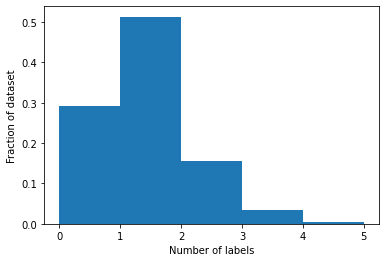

In [33]:
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

## Majority modeling based on the number of labelling function output of data

In [34]:
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [35]:
preds_train

array([ 1, -1, -1, ...,  1,  1,  1])

## Checking accuracy of majority label voter model

In [36]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [37]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   74.4%
Label Model Accuracy:     75.2%


## Filter out data points with no label

In [39]:
probs_train = label_model.predict_proba(L=L_train)

In [40]:
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

## Classification on labelled data

In [41]:
vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())

In [42]:
preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [43]:
sklearn_model = LogisticRegression(C=1e3, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 81.6%
